# 环境

  为实验安装需要用到的库

In [ ]:
# !pip install datasets
# !pip install factor_analyzer
# !pip install xlwt
# !pip install seaborn
# !pip install gensim

# 准备数据

In [1]:
from datasets import load_dataset

dataset = load_dataset('imdb')

print(len(dataset['train']), len(dataset['test']), len(dataset['unsupervised']))
print(dataset['train'][0])

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

25000 25000 50000
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes 

# 训练词向量

  首先预处理文本，分词和去除标点符号。

In [2]:
# 对于每一段评论文本，去除标点符号和换行符，单词间空格相连
# 需注意，当前处理方法没有把单词中的标点符号去掉
def no_space(char, prev_char):
    return char in set(',.!?') and prev_char != ' ' and ord(prev_char) >= 97


def preprocess(sentence):
    sentence = sentence.strip('\n').replace('<br /><br />', ' ').replace('(', '').replace(')', '')
    out = [' ' + char if i > 0 and no_space(char, sentence[i - 1]) else char
        for i, char in enumerate(sentence)]
    return ''.join(out)


processed = []
for onedata in dataset['train']:
    processed.append(preprocess(onedata['text']))

print(processed[0])

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country , therefore being a fan of films considered "controversial" I really had to see this for myself . The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life . In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States . In between asking politicians and ordinary denizens of Stockholm about their opinions on politics , she has sex with her drama teacher , classmates , and married men . What kills me about I AM CURIOUS-YELLOW is that 40 years ago , this was considered pornographic . Really , the sex and nudity scenes are few and far between , even then it'

In [3]:
punc = set(',.?!')
words = [[word for word in sen.split(' ') if word not in punc] for sen in processed]
len(words), len(words[0])

(25000, 285)

In [5]:
# 训练词向量
from gensim.models import word2vec

file_path = 'autodl-tmp/fam_classifier/imdb/'
model = word2vec.Word2Vec(sentences=words, vector_size=512, sg=1, min_count=5)

In [7]:
model.save(file_path + "imdb_word_vec_sg.bin")

# 因子分析

In [13]:
import numpy as np
import pandas as pd
from d2l import torch as d2l
import matplotlib.pyplot as plt
import seaborn as sns
import math
from gensim.models import word2vec
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

In [ ]:
# 加载训练好的word2vec模型
model = word2vec.Word2Vec.load(file_path + 'imdb_word_vec_sg.bin')
embedding = np.array([model.wv[word] for word in model.wv.index_to_key])
print(embedding.shape)

# 查看单词的词向量
# model.wv['fascinating']

In [14]:
# Bartlett's球状检验
print('Bartlett\'s球状检验: 检验总体变量的相关矩阵是否是单位阵')
chi_square_value, p_value = calculate_bartlett_sphericity(embedding)
print(chi_square_value, p_value)

# 导入kmo检验
print('kmo检验:')
print('检查变量间的相关性和偏相关性，取值在0-1之间；KMO统计量越接近1，变量间的相关性越强，偏相关性越弱，因子分析的效果越好')
kmo_all, kmo_model = calculate_kmo(embedding)
print('KMO值为: ', kmo_model)

Bartlett's球状检验: 检验总体变量的相关矩阵是否是单位阵
inf 0.0
kmo检验:
检查变量间的相关性和偏相关性，取值在0-1之间；KMO统计量越接近1，变量间的相关性越强，偏相关性越弱，因子分析的效果越好


/root/miniconda3/lib/python3.8/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


KMO值为:  0.7628552186586137


In [15]:
# 因子分析
fa = FactorAnalyzer(25, rotation=None)
# fa = FactorAnalyzer(25, rotation='varimax')
fa.fit(embedding)

# 特征值、特征向量
ev, v = fa.get_eigenvalues()

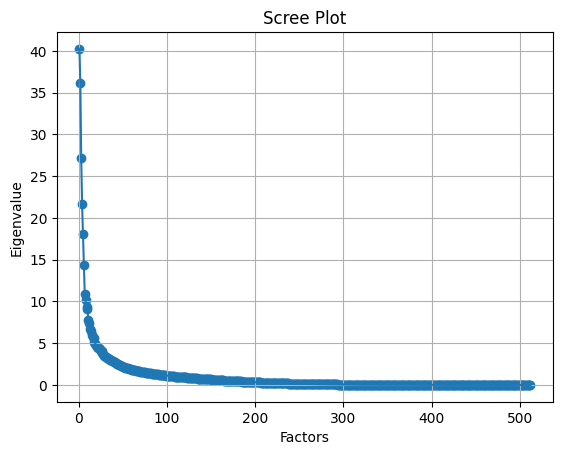

<Figure size 640x480 with 0 Axes>

In [17]:
# 可视化
# plot横轴是指标个数，纵轴是ev值
plt.scatter(range(1, embedding.shape[1]+1), ev)
plt.plot(range(1, embedding.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

plt.savefig(file_path + 'ev.png')

In [22]:
df_ev = pd.DataFrame({"index": range(1, embedding.shape[1]+1),
                     "evalue": ev})
df_ev.to_excel(file_path + 'ev_output.xlsx')

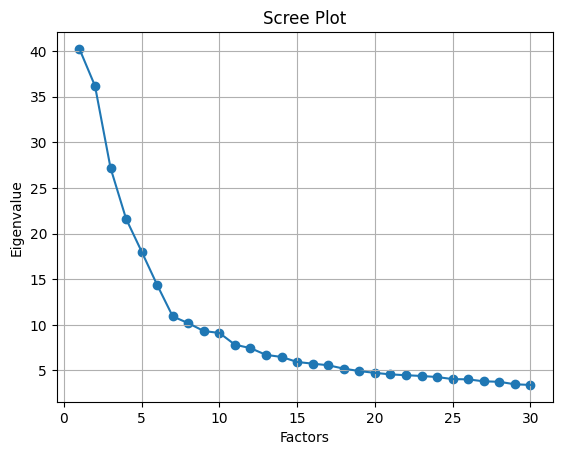

<Figure size 640x480 with 0 Axes>

In [23]:
# 更清晰的展示前三十个
plt.scatter(range(1, 31), ev[:30])
plt.plot(range(1, 31), ev[:30])
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()
plt.savefig(file_path + 'ev30.png')

In [24]:
# 上图表示，八个因子已经承载了足够多的特征值，确定因子数为8进行因子分析
fa = FactorAnalyzer(8, rotation="promax")
fa.fit(embedding)
print(fa.loadings_.shape)

# 保存因子分析的结果
# 512*8(变量个数*因子个数)
index = fa.loadings_.argmax(axis=1)
res = np.array([[i, idx] for i, idx in enumerate(index)])

data_1 = pd.DataFrame(fa.loadings_, columns=['fa1', 'fa2', 'fa3', 'fa4', 'fa5', 'fa6', 'fa7', 'fa8'])
data_2 = pd.DataFrame(res, columns=['Dimension', 'Factor'])
with pd.ExcelWriter(file_path + "FAoutput.xls") as writer1:
    data_1.to_excel(writer1, sheet_name="Sheet1")
    data_2.to_excel(writer1, sheet_name="Sheet2")
    writer1.save()

(512, 8)


/root/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3473: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  if (await self.run_code(code, result,  async_=asy)):


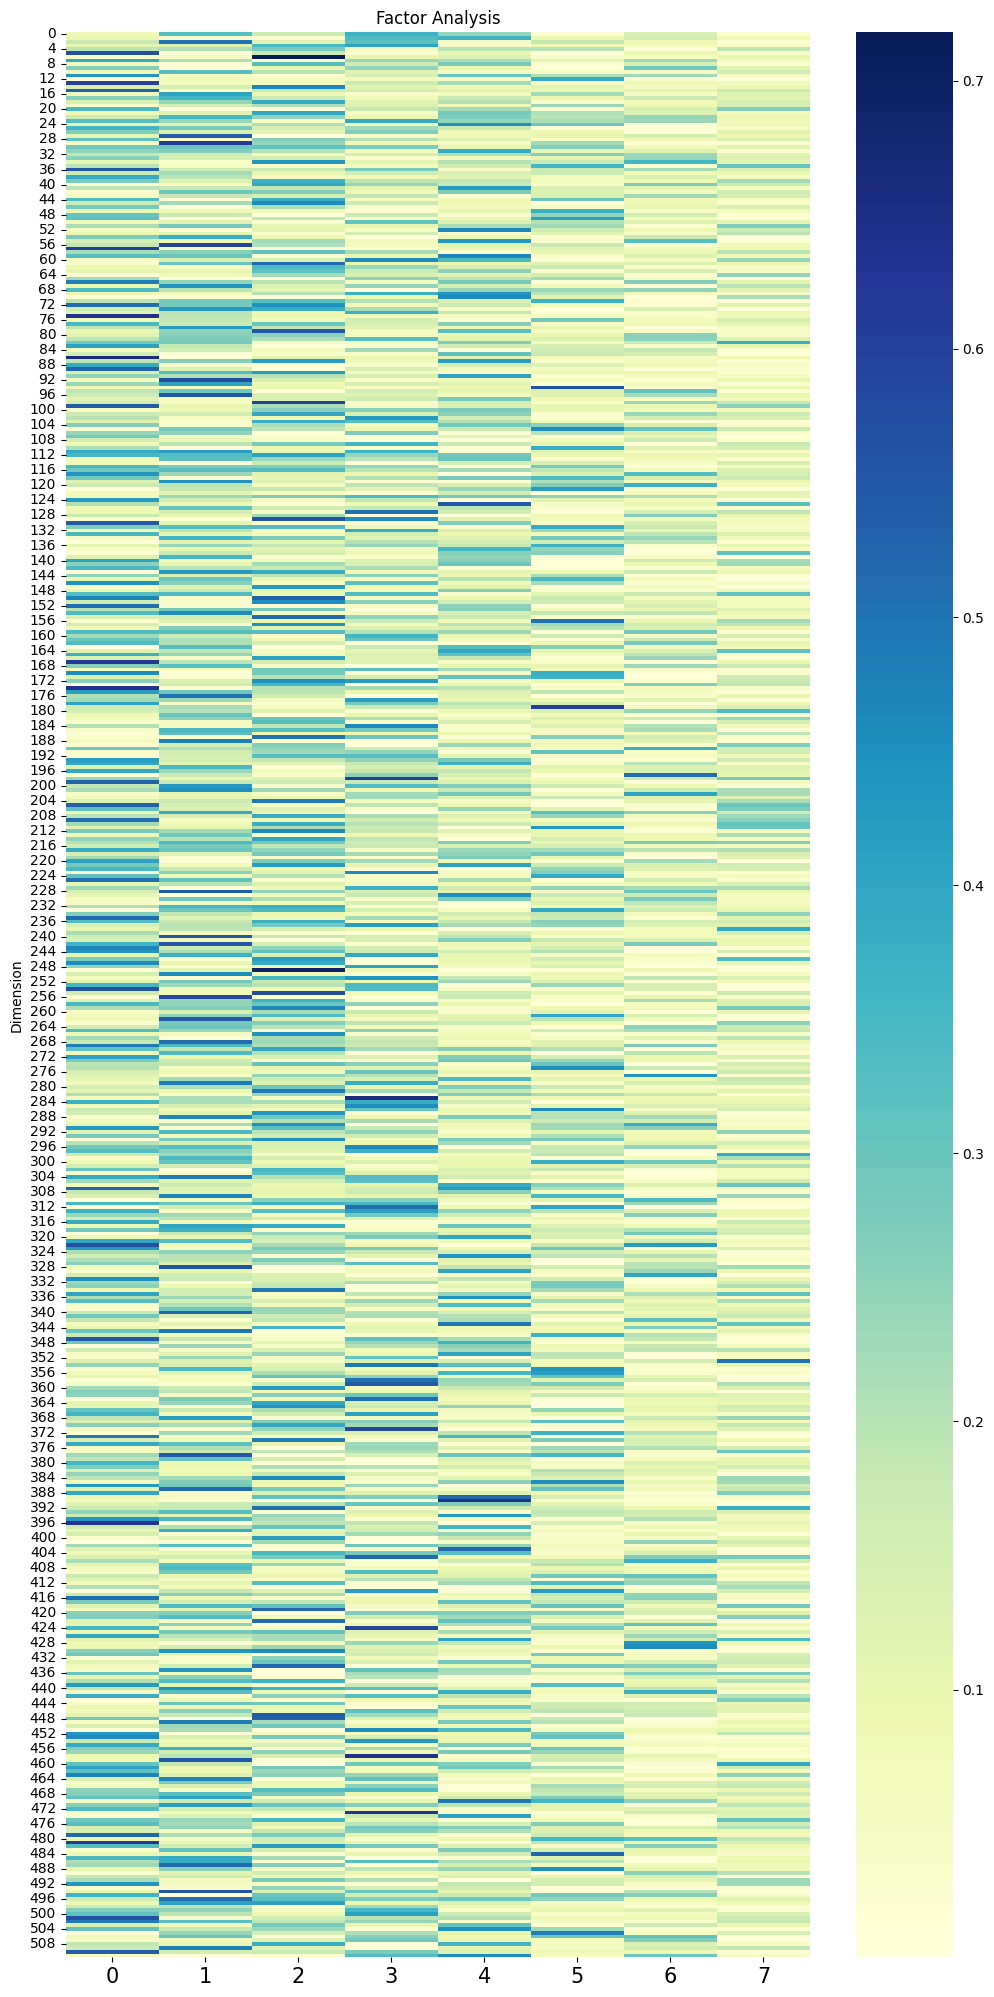

In [25]:
# 因子分析结果可视化
df_cm = pd.DataFrame(np.abs(fa.loadings_))
fig, ax = plt.subplots(figsize=(12, 25))
sns.heatmap(df_cm, annot=None, cmap='YlGnBu', ax=ax)  # cbar_kws

ax.tick_params(axis='x', labelsize=15)
ax.set_title("Factor Analysis", fontsize=12)
ax.set_ylabel("Dimension")
plt.savefig(file_path + 'FAdimension.png')

# 模型架构

In [4]:
# 做完因子分析得到结果后，接下来的模型构建和训练和前面关系不大了
# 每次引用下面这些库就足够
import torch
from torch import nn
import numpy as np
import pandas as pd
from d2l import torch as d2l
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
import time
import math
from gensim.models import word2vec

In [5]:
class FAMAttention(nn.Module):
    """修改多头注意力，针对嵌入512维，8个head的模型"""

    def __init__(self, num_hiddens, dim_dict, dropout, bias=False, **kwargs):
        super(FAMAttention, self).__init__(**kwargs)
        self.attention = d2l.DotProductAttention(dropout)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        self.dim_dict = dim_dict
        self.dim_0 = [dim for dim, idx in self.dim_dict.items() if idx == 0]
        self.dim_1 = [dim for dim, idx in self.dim_dict.items() if idx == 1]
        self.dim_2 = [dim for dim, idx in self.dim_dict.items() if idx == 2]
        self.dim_3 = [dim for dim, idx in self.dim_dict.items() if idx == 3]
        self.dim_4 = [dim for dim, idx in self.dim_dict.items() if idx == 4]
        self.dim_5 = [dim for dim, idx in self.dim_dict.items() if idx == 5]
        self.dim_6 = [dim for dim, idx in self.dim_dict.items() if idx == 6]
        self.dim_7 = [dim for dim, idx in self.dim_dict.items() if idx == 7]
        # self.list_concat = torch.cat((self.dim_0, self.dim_1, self.dim_2, self.dim_3, self.dim_4, self.dim_5,
        # self.dim_6, self.dim_7))
        self.len_0, self.len_1, self.len_2, self.len_3, self.len_4, self.len_5, self.len_6, self.len_7 = len(
            self.dim_0), len(self.dim_1), len(self.dim_2), len(self.dim_3), len(self.dim_4), len(self.dim_5),\
            len(self.dim_6), len(self.dim_7)

        self.Wq0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wq1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wq2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wq3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wq4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wq5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wq6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wq7 = nn.Linear(self.len_7, self.len_7, bias=bias)

        self.Wk0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wk1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wk2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wk3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wk4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wk5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wk6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wk7 = nn.Linear(self.len_7, self.len_7, bias=bias)

        self.Wv0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wv1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wv2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wv3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wv4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wv5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wv6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wv7 = nn.Linear(self.len_7, self.len_7, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        def assemble(output_concat, list_concat):
            reslist = []
            for i in range(512):
                reslist.append(list_concat.index(i))
            return torch.index_select(output_concat, -1, torch.tensor(reslist, device=output_concat.device))

        # queries, keys, values的形状: (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # qi, ki, vi的形状：(batch_size, 查询或者“键－值”对的个数， self.len_i)
        q0, k0, v0 = torch.index_select(queries, -1, torch.tensor(self.dim_0, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_0, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_0, device=values.device))
        q1, k1, v1 = torch.index_select(queries, -1, torch.tensor(self.dim_1, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_1, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_1, device=values.device))
        q2, k2, v2 = torch.index_select(queries, -1, torch.tensor(self.dim_2, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_2, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_2, device=values.device))
        q3, k3, v3 = torch.index_select(queries, -1, torch.tensor(self.dim_3, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_3, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_3, device=values.device))
        q4, k4, v4 = torch.index_select(queries, -1, torch.tensor(self.dim_4, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_4, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_4, device=values.device))
        q5, k5, v5 = torch.index_select(queries, -1, torch.tensor(self.dim_5, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_5, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_5, device=values.device))
        q6, k6, v6 = torch.index_select(queries, -1, torch.tensor(self.dim_6, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_6, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_6, device=values.device))
        q7, k7, v7 = torch.index_select(queries, -1, torch.tensor(self.dim_7, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_7, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_7, device=values.device))

        head0 = self.attention(self.Wq0(q0), self.Wk0(k0), self.Wv0(v0), valid_lens)
        head1 = self.attention(self.Wq1(q1), self.Wk1(k1), self.Wv1(v1), valid_lens)
        head2 = self.attention(self.Wq2(q2), self.Wk2(k2), self.Wv2(v2), valid_lens)
        head3 = self.attention(self.Wq3(q3), self.Wk3(k3), self.Wv3(v3), valid_lens)
        head4 = self.attention(self.Wq4(q4), self.Wk4(k4), self.Wv4(v4), valid_lens)
        head5 = self.attention(self.Wq5(q5), self.Wk5(k5), self.Wv5(v5), valid_lens)
        head6 = self.attention(self.Wq6(q6), self.Wk6(k6), self.Wv6(v6), valid_lens)
        head7 = self.attention(self.Wq7(q7), self.Wk7(k7), self.Wv7(v7), valid_lens)

        output_concat = torch.cat((head0, head1, head2, head3, head4, head5, head6, head7), dim=-1)
        list_concat = self.dim_0 + self.dim_1 + self.dim_2 + self.dim_3 + self.dim_4 + self.dim_5 + self.dim_6 + self.dim_7
        return self.W_o(assemble(output_concat, list_concat))

In [6]:
# 编码器块
class EncoderBlock(nn.Module):
    """修改的编码器块"""

    def __init__(self, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, dim_dict, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = FAMAttention(num_hiddens, dim_dict, dropout, use_bias)
        self.addnorm1 = d2l.AddNorm(norm_shape, dropout)
        self.ffn = d2l.PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = d2l.AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [7]:
# 编码器
class FAMEncoder(d2l.Encoder):
    """修改的编码器"""

    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, dim_dict, num_layers, dropout, num_output,
                 use_bias=False, **kwargs):
        super(FAMEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        self.outhidden = nn.Sequential(
                                    nn.Linear(num_hiddens, num_hiddens),
                                    nn.ReLU())
        self.Dense = nn.Linear(num_hiddens, num_output)
        for i in range(num_layers):
            self.blks.add_module("block" + str(i),
                                 EncoderBlock(num_hiddens, norm_shape, ffn_num_input,
                                              ffn_num_hiddens, dim_dict, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        # 取句首'cls'token的向量用于情感分类
        return self.Dense(self.outhidden(X[:, 0, :]))

# 加载训练数据

In [8]:
# 生成词表
def load_datawords(dataset):
    processed = []
    for onedata in dataset:
        processed.append(preprocess(onedata['text']))

    punc = set(',.?!')
    words = [[word for word in sen.split(' ') if word not in punc] for sen in processed]
    return [['<cls>'] + line for line in words]


train_words = load_datawords(dataset['train'])
vocab = d2l.Vocab(train_words, min_freq=5, reserved_tokens=['<pad>', '<cls>'])
print('词表大小: ', len(vocab))
print('前50个token: ', vocab.idx_to_token[:50])

词表大小:  37652
前50个token:  ['<unk>', '<pad>', '<cls>', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'I', 'that', 'it', 'this', 'was', 'as', 'with', 'movie', 'for', 'The', 'film', 'but', 'on', 'are', 'his', 'not', 'have', 'you', 'be', 'one', 'he', 'at', 'by', 'all', 'an', 'who', 'from', 'like', 'they', 'her', 'so', 'about', 'or', 'has', 'just', 'out', 'This', 'some', 'good', 'more']


In [9]:
# 生成训练数据集、测试数据集
# 每条数据包括: (语句词元, 语句有效长度, 标签)
def load_imdb_data(datawords, vocab, dataset, batch_size, num_steps):
    data_tokens = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in datawords])
    valid_lens = (data_tokens != vocab['<pad>']).type(torch.int32).sum(1)
    labels = torch.tensor(dataset[:]['label'])
    return d2l.load_array((data_tokens, valid_lens, labels), batch_size)


batch_size, num_steps = 64, 500
train_iter = load_imdb_data(train_words, vocab, dataset['train'], batch_size, num_steps)
for X, valid_len, y in train_iter:
    print('X:', X.shape, ', y:', y.shape, ', valid_len:', valid_len.shape)
    break
print('小批量数目：', len(train_iter))


# 测试集
test_words = load_datawords(dataset['test'])

test_iter = load_imdb_data(test_words, vocab, dataset['test'], 64, 500)

X: torch.Size([64, 500]) , y: torch.Size([64]) , valid_len: torch.Size([64])
小批量数目： 391


In [13]:
from collections import Counter
Counter(dataset['test']['label'])

Counter({0: 12500, 1: 12500})

# 模型训练

In [22]:
# 参数和超参数
num_hiddens, num_layers, dropout, num_output = 512, 3, 0.1, 2
ffn_num_input, ffn_num_hiddens, num_heads, norm_shape = 512, 2048, 8, [512]
lr, num_epochs, device = 5e-5, 60, d2l.try_gpu()

In [23]:
file_path = '/root//autodl-tmp/fam_classifier/imdb/'

In [24]:
# 因子分析结果
excelfile = pd.read_excel(file_path + 'FAoutput.xls', sheet_name='Sheet2', header=0, index_col=0)
dim_dict = dict()
for i in range(512):
    dim_dict[excelfile['Dimension'].values[i]] = excelfile['Factor'].values[i]

In [25]:
# 实例化模型, 打印模型参数数量
net = FAMEncoder(
    len(vocab), num_hiddens, norm_shape,
    ffn_num_input, ffn_num_hiddens, dim_dict,
    num_layers,dropout, num_output)

# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

26,952,088 total parameters.
26,952,088 training parameters.


In [26]:
# 用word2vector训练的词向量来初始化embedding层模型权重
def get_embedding_weights(vocab, word2vecmodel, num_hiddens):
    wordlist = word2vecmodel.wv.index_to_key
    n = len(vocab)
    data = np.random.randn(n, num_hiddens)
    for i in range(n):
        word = vocab.idx_to_token[i]
        data[i] = np.array(word2vecmodel.wv[word]) if word in wordlist else data[i]
    return torch.tensor(data, dtype=torch.float32)


def init_embedding_weights(net, weights):
    for m in net.modules():
        if isinstance(m, nn.Embedding):
            m.weight.data = weights


word2vecmodel = word2vec.Word2Vec.load(file_path + 'imdb_word_vec_sg.bin')
weights = get_embedding_weights(vocab, word2vecmodel, num_hiddens)
init_embedding_weights(net, weights)

In [27]:
# 用Xavier初始化线性层权重
def xavier_init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)


net.apply(xavier_init_weights)

FAMEncoder(
  (embedding): Embedding(37652, 512)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blks): Sequential(
    (block0): EncoderBlock(
      (attention): FAMAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_o): Linear(in_features=512, out_features=512, bias=False)
        (Wq0): Linear(in_features=89, out_features=89, bias=False)
        (Wq1): Linear(in_features=83, out_features=83, bias=False)
        (Wq2): Linear(in_features=73, out_features=73, bias=False)
        (Wq3): Linear(in_features=69, out_features=69, bias=False)
        (Wq4): Linear(in_features=66, out_features=66, bias=False)
        (Wq5): Linear(in_features=58, out_features=58, bias=False)
        (Wq6): Linear(in_features=43, out_features=43, bias=False)
        (Wq7): Linear(in_features=31, out_features=31, bias=False)
        (Wk0): Linear(in_features=89, out_features=89, bias=False)
      

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for data in data_iter:
            if isinstance(data, list) or isinstance(data, tuple):
                X, valid_len, y = [x.to(device) for x in data]
            else:
                X = X.to(device)
            metric.add(d2l.accuracy(net(X, valid_len), y), d2l.size(y))
    return metric[0] / metric[1]

In [28]:
# 定义评估模型准确率和F1指标的函数
from sklearn.metrics import accuracy_score, f1_score
# f1_score(labels, predicitons, average='micro')
def evaluate_accuracy_f1(net, data_iter, device=None):
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device

    y_pred, y_true = torch.tensor([], device=device), torch.tensor([], device=device)
    with torch.no_grad():
        for data in data_iter:
            if isinstance(data, list) or isinstance(data, tuple):
                X, valid_len, y = [x.to(device) for x in data]
            else:
                X = X.to(device)
            y_pred = torch.cat([y_pred, net(X, valid_len).argmax(dim=-1)])
            y_true = torch.cat([y_true, y])
    return accuracy_score(y_pred.cpu(), y_true.cpu()), f1_score(y_pred.cpu(), y_true.cpu())

In [44]:
evaluate_accuracy_f1(net, test_iter)

(0.49944, 0.6660083271057969)

In [39]:
torch.tensor([]).shape

torch.Size([0])

## 正式训练-两层FAM

  由于模型的embedding层用word2vec词向量进行了初始化，可以认为嵌入层现在已经有了一定的信息表征能力，因此在接下来的训练过程里，给该层的参数一个较小的学习率，而给其他层更大的学习率(这里用的10倍)。已有的训练结果表示这样的微调方法产生的结果是不错的，但是不否认有更好的训练方式。

In [24]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 24,492,514 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
# 为不同层赋予不同的学习率
forward_params = [
    param for name, param in net.named_parameters()
    if name != "embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': net.embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
train_f1, test_f1 = [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        X, valid_len, y = [v.to(device) for v in data]
        l = loss(net(X, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        # train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss = train_loss / num_batches
    epochtrainacc, epochtrainf1 =evaluate_accuracy_f1(net, test_iter)
    epochtestacc, epochtestf1 = evaluate_accuracy_f1(net, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrainacc:.3f}, '
        f'train_f1 {epochtrainf1:.3f}, test_acc {epochtestacc:.3f},'
        f'test_f1 {epochtestf1:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrainacc)
    train_f1.append(epochtrainf1)
    test_accuracy.append(epochtestacc)
    test_f1.append(epochtestf1)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'训练集f1:{train_f1[-1]:.3f}, 测试集准确率:{test_accuracy[-1]:.3f}, '
     f'测试集f1:{train_f1[-1]:.3f}, 在设备{device}上训练{num_epochs}周期, 耗时{total_timecost} s')

100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 1, loss 0.720, train_acc 0.756, train_f1 0.744, test_acc 0.756,test_f1 0.744, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.18it/s]


epoch 2, loss 0.503, train_acc 0.807, train_f1 0.819, test_acc 0.807,test_f1 0.819, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 3, loss 0.423, train_acc 0.829, train_f1 0.820, test_acc 0.829,test_f1 0.820, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


epoch 4, loss 0.398, train_acc 0.831, train_f1 0.821, test_acc 0.831,test_f1 0.821, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 5, loss 0.377, train_acc 0.846, train_f1 0.856, test_acc 0.846,test_f1 0.856, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.18it/s]


epoch 6, loss 0.359, train_acc 0.857, train_f1 0.858, test_acc 0.857,test_f1 0.858, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.15it/s]


epoch 7, loss 0.349, train_acc 0.857, train_f1 0.862, test_acc 0.857,test_f1 0.862, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.14it/s]


epoch 8, loss 0.332, train_acc 0.865, train_f1 0.867, test_acc 0.865,test_f1 0.867, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


epoch 9, loss 0.324, train_acc 0.868, train_f1 0.870, test_acc 0.868,test_f1 0.870, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


epoch 10, loss 0.314, train_acc 0.868, train_f1 0.866, test_acc 0.868,test_f1 0.866, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 11, loss 0.299, train_acc 0.872, train_f1 0.874, test_acc 0.872,test_f1 0.874, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 12, loss 0.295, train_acc 0.872, train_f1 0.870, test_acc 0.872,test_f1 0.870, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


epoch 13, loss 0.278, train_acc 0.872, train_f1 0.877, test_acc 0.872,test_f1 0.877, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 14, loss 0.271, train_acc 0.877, train_f1 0.877, test_acc 0.877,test_f1 0.877, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.18it/s]


epoch 15, loss 0.262, train_acc 0.875, train_f1 0.874, test_acc 0.875,test_f1 0.874, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.19it/s]


epoch 16, loss 0.248, train_acc 0.851, train_f1 0.864, test_acc 0.851,test_f1 0.864, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.19it/s]


epoch 17, loss 0.242, train_acc 0.871, train_f1 0.866, test_acc 0.871,test_f1 0.866, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 18, loss 0.228, train_acc 0.869, train_f1 0.872, test_acc 0.869,test_f1 0.872, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


epoch 19, loss 0.217, train_acc 0.856, train_f1 0.864, test_acc 0.856,test_f1 0.864, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


epoch 20, loss 0.200, train_acc 0.867, train_f1 0.867, test_acc 0.867,test_f1 0.867, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


epoch 21, loss 0.191, train_acc 0.863, train_f1 0.865, test_acc 0.863,test_f1 0.865, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 22, loss 0.192, train_acc 0.858, train_f1 0.856, test_acc 0.858,test_f1 0.856, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.19it/s]


epoch 23, loss 0.171, train_acc 0.854, train_f1 0.849, test_acc 0.854,test_f1 0.849, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.19it/s]


epoch 24, loss 0.156, train_acc 0.858, train_f1 0.859, test_acc 0.858,test_f1 0.859, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.18it/s]


epoch 25, loss 0.152, train_acc 0.855, train_f1 0.849, test_acc 0.855,test_f1 0.849, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 26, loss 0.143, train_acc 0.855, train_f1 0.854, test_acc 0.855,test_f1 0.854, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.18it/s]


epoch 27, loss 0.129, train_acc 0.847, train_f1 0.841, test_acc 0.847,test_f1 0.841, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.18it/s]


epoch 28, loss 0.122, train_acc 0.846, train_f1 0.848, test_acc 0.846,test_f1 0.848, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


epoch 29, loss 0.113, train_acc 0.848, train_f1 0.847, test_acc 0.848,test_f1 0.847, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


epoch 30, loss 0.111, train_acc 0.840, train_f1 0.838, test_acc 0.840,test_f1 0.838, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.15it/s]


epoch 31, loss 0.101, train_acc 0.842, train_f1 0.846, test_acc 0.842,test_f1 0.846, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.19it/s]


epoch 32, loss 0.104, train_acc 0.829, train_f1 0.840, test_acc 0.829,test_f1 0.840, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 33, loss 0.099, train_acc 0.846, train_f1 0.842, test_acc 0.846,test_f1 0.842, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.18it/s]


epoch 34, loss 0.099, train_acc 0.822, train_f1 0.807, test_acc 0.822,test_f1 0.807, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


epoch 35, loss 0.087, train_acc 0.853, train_f1 0.853, test_acc 0.853,test_f1 0.853, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.18it/s]


epoch 36, loss 0.082, train_acc 0.846, train_f1 0.845, test_acc 0.846,test_f1 0.845, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 37, loss 0.081, train_acc 0.841, train_f1 0.835, test_acc 0.841,test_f1 0.835, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


epoch 38, loss 0.077, train_acc 0.832, train_f1 0.829, test_acc 0.832,test_f1 0.829, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.18it/s]


epoch 39, loss 0.074, train_acc 0.841, train_f1 0.843, test_acc 0.841,test_f1 0.843, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.18it/s]


epoch 40, loss 0.072, train_acc 0.817, train_f1 0.796, test_acc 0.817,test_f1 0.796, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 41, loss 0.069, train_acc 0.843, train_f1 0.837, test_acc 0.843,test_f1 0.837, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 42, loss 0.068, train_acc 0.843, train_f1 0.846, test_acc 0.843,test_f1 0.846, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 43, loss 0.067, train_acc 0.830, train_f1 0.841, test_acc 0.830,test_f1 0.841, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 44, loss 0.054, train_acc 0.840, train_f1 0.845, test_acc 0.840,test_f1 0.845, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 45, loss 0.054, train_acc 0.838, train_f1 0.837, test_acc 0.838,test_f1 0.837, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 46, loss 0.054, train_acc 0.831, train_f1 0.826, test_acc 0.831,test_f1 0.826, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


epoch 47, loss 0.053, train_acc 0.839, train_f1 0.846, test_acc 0.839,test_f1 0.846, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 48, loss 0.049, train_acc 0.834, train_f1 0.833, test_acc 0.834,test_f1 0.833, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.18it/s]


epoch 49, loss 0.055, train_acc 0.825, train_f1 0.815, test_acc 0.825,test_f1 0.815, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


epoch 50, loss 0.049, train_acc 0.831, train_f1 0.839, test_acc 0.831,test_f1 0.839, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


epoch 51, loss 0.049, train_acc 0.836, train_f1 0.833, test_acc 0.836,test_f1 0.833, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 52, loss 0.050, train_acc 0.818, train_f1 0.808, test_acc 0.818,test_f1 0.808, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.18it/s]


epoch 53, loss 0.045, train_acc 0.829, train_f1 0.824, test_acc 0.829,test_f1 0.824, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.20it/s]


epoch 54, loss 0.044, train_acc 0.817, train_f1 0.802, test_acc 0.817,test_f1 0.802, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


epoch 55, loss 0.044, train_acc 0.834, train_f1 0.829, test_acc 0.834,test_f1 0.829, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


epoch 56, loss 0.046, train_acc 0.818, train_f1 0.802, test_acc 0.818,test_f1 0.802, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.20it/s]


epoch 57, loss 0.038, train_acc 0.818, train_f1 0.803, test_acc 0.818,test_f1 0.803, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


epoch 58, loss 0.037, train_acc 0.839, train_f1 0.842, test_acc 0.839,test_f1 0.842, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.19it/s]


epoch 59, loss 0.035, train_acc 0.844, train_f1 0.840, test_acc 0.844,test_f1 0.840, taking 97 seconds


100%|██████████| 391/391 [00:54<00:00,  7.12it/s]


epoch 60, loss 0.037, train_acc 0.832, train_f1 0.837, test_acc 0.832,test_f1 0.837, taking 97 seconds
Training is finished.
训练损失:0.037, 训练集准确率:0.832, 训练集f1:0.837, 测试集准确率:0.832, 测试集f1:0.837, 在设备cuda:0上训练60周期, 耗时5813 s


## 保存结果

  对于画图效果的调整，可以参考网站https://blog.csdn.net/weixin_43384257/article/details/115640104, https://blog.csdn.net/qq_41870157/article/details/104328111
网上matplotlib的教程很多。

In [25]:
print(f"测试集最佳准确率: {max(test_accuracy):.3f},\n"
    f"测试集最佳F1分数: {max(test_f1):.3f}")

测试集最佳准确率: 0.877,
测试集最佳F1分数: 0.877


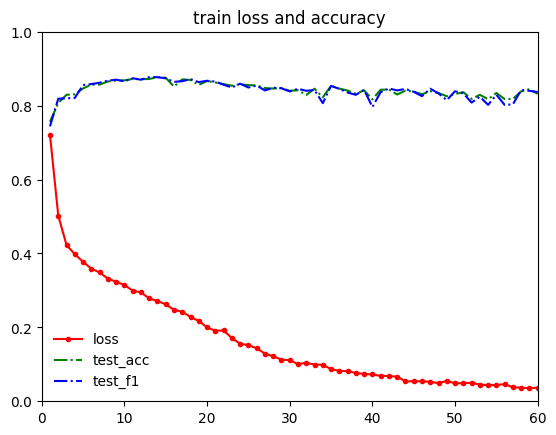

In [27]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
plt.axis([0, num_epochs, 0, 1])
# losses, train_accuracy, test_accuracy, test_f1
plt.plot(epochs, losses, 'r.-', label='loss')
# plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'g-.', label='test_acc')
plt.plot(epochs, test_f1, 'b-.', label='test_f1')
plt.legend(loc='best', frameon=False)
plt.show()

In [28]:
result = pd.DataFrame({"train_acc": train_accuracy,
                       "train_f1": train_f1,
                      "test_acc": test_accuracy,
                      "test_f1": test_f1})
result.to_excel(file_path + 'output/2layerfa.xlsx')

In [29]:
torch.save(net.state_dict(), file_path + 'output/2layer_state_dict.pth')

## 正式训练-三层FAM

In [29]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 26,952,088 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
# 为不同层赋予不同的学习率
forward_params = [
    param for name, param in net.named_parameters()
    if name != "embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': net.embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
train_f1, test_f1 = [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        X, valid_len, y = [v.to(device) for v in data]
        l = loss(net(X, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        # train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss = train_loss / num_batches
    epochtrainacc, epochtrainf1 = evaluate_accuracy_f1(net, train_iter)
    epochtestacc, epochtestf1 = evaluate_accuracy_f1(net, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrainacc:.3f}, '
        f'train_f1 {epochtrainf1:.3f}, test_acc {epochtestacc:.3f},'
        f'test_f1 {epochtestf1:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrainacc)
    train_f1.append(epochtrainf1)
    test_accuracy.append(epochtestacc)
    test_f1.append(epochtestf1)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'训练集f1:{train_f1[-1]:.3f}, 测试集准确率:{test_accuracy[-1]:.3f}, '
     f'测试集f1:{train_f1[-1]:.3f}, 在设备{device}上训练{num_epochs}周期, 耗时{total_timecost} s')

100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 1, loss 0.739, train_acc 0.500, train_f1 0.000, test_acc 0.500,test_f1 0.000, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.83it/s]


epoch 2, loss 0.703, train_acc 0.500, train_f1 0.667, test_acc 0.500,test_f1 0.667, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 3, loss 0.701, train_acc 0.500, train_f1 0.667, test_acc 0.500,test_f1 0.667, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.84it/s]


epoch 4, loss 0.698, train_acc 0.500, train_f1 0.667, test_acc 0.500,test_f1 0.667, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.83it/s]


epoch 5, loss 0.689, train_acc 0.500, train_f1 0.000, test_acc 0.500,test_f1 0.000, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 6, loss 0.607, train_acc 0.700, train_f1 0.764, test_acc 0.701,test_f1 0.764, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 7, loss 0.480, train_acc 0.803, train_f1 0.825, test_acc 0.798,test_f1 0.820, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 8, loss 0.421, train_acc 0.799, train_f1 0.826, test_acc 0.792,test_f1 0.820, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 9, loss 0.391, train_acc 0.818, train_f1 0.840, test_acc 0.809,test_f1 0.832, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 10, loss 0.357, train_acc 0.864, train_f1 0.859, test_acc 0.849,test_f1 0.842, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 11, loss 0.346, train_acc 0.858, train_f1 0.868, test_acc 0.850,test_f1 0.859, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 12, loss 0.335, train_acc 0.864, train_f1 0.854, test_acc 0.839,test_f1 0.824, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 13, loss 0.321, train_acc 0.889, train_f1 0.890, test_acc 0.863,test_f1 0.864, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 14, loss 0.302, train_acc 0.899, train_f1 0.900, test_acc 0.865,test_f1 0.867, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 15, loss 0.295, train_acc 0.898, train_f1 0.898, test_acc 0.865,test_f1 0.864, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 16, loss 0.285, train_acc 0.903, train_f1 0.907, test_acc 0.870,test_f1 0.874, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 17, loss 0.271, train_acc 0.914, train_f1 0.915, test_acc 0.868,test_f1 0.871, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 18, loss 0.264, train_acc 0.915, train_f1 0.916, test_acc 0.873,test_f1 0.875, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 19, loss 0.259, train_acc 0.919, train_f1 0.917, test_acc 0.868,test_f1 0.865, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 20, loss 0.250, train_acc 0.925, train_f1 0.923, test_acc 0.865,test_f1 0.860, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 21, loss 0.239, train_acc 0.933, train_f1 0.933, test_acc 0.868,test_f1 0.865, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 22, loss 0.230, train_acc 0.934, train_f1 0.936, test_acc 0.864,test_f1 0.868, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 23, loss 0.217, train_acc 0.943, train_f1 0.944, test_acc 0.865,test_f1 0.866, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 24, loss 0.208, train_acc 0.947, train_f1 0.947, test_acc 0.867,test_f1 0.866, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.83it/s]


epoch 25, loss 0.204, train_acc 0.953, train_f1 0.954, test_acc 0.865,test_f1 0.864, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 26, loss 0.191, train_acc 0.952, train_f1 0.953, test_acc 0.866,test_f1 0.870, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 27, loss 0.179, train_acc 0.958, train_f1 0.957, test_acc 0.859,test_f1 0.853, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 28, loss 0.176, train_acc 0.960, train_f1 0.960, test_acc 0.858,test_f1 0.862, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.83it/s]


epoch 29, loss 0.161, train_acc 0.966, train_f1 0.966, test_acc 0.856,test_f1 0.860, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 30, loss 0.162, train_acc 0.971, train_f1 0.971, test_acc 0.858,test_f1 0.854, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 31, loss 0.149, train_acc 0.974, train_f1 0.974, test_acc 0.856,test_f1 0.850, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 32, loss 0.140, train_acc 0.977, train_f1 0.977, test_acc 0.854,test_f1 0.850, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 33, loss 0.131, train_acc 0.978, train_f1 0.978, test_acc 0.851,test_f1 0.855, taking 145 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 34, loss 0.122, train_acc 0.983, train_f1 0.983, test_acc 0.855,test_f1 0.850, taking 145 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 35, loss 0.108, train_acc 0.982, train_f1 0.982, test_acc 0.847,test_f1 0.845, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.83it/s]


epoch 36, loss 0.107, train_acc 0.982, train_f1 0.982, test_acc 0.857,test_f1 0.858, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 37, loss 0.101, train_acc 0.981, train_f1 0.982, test_acc 0.845,test_f1 0.851, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 38, loss 0.099, train_acc 0.974, train_f1 0.975, test_acc 0.830,test_f1 0.843, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 39, loss 0.095, train_acc 0.987, train_f1 0.987, test_acc 0.848,test_f1 0.853, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 40, loss 0.085, train_acc 0.989, train_f1 0.989, test_acc 0.848,test_f1 0.846, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.83it/s]


epoch 41, loss 0.084, train_acc 0.988, train_f1 0.988, test_acc 0.837,test_f1 0.826, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 42, loss 0.081, train_acc 0.990, train_f1 0.990, test_acc 0.848,test_f1 0.847, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 43, loss 0.074, train_acc 0.993, train_f1 0.993, test_acc 0.835,test_f1 0.831, taking 145 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 44, loss 0.069, train_acc 0.993, train_f1 0.993, test_acc 0.840,test_f1 0.837, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.83it/s]


epoch 45, loss 0.069, train_acc 0.988, train_f1 0.988, test_acc 0.832,test_f1 0.843, taking 145 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 46, loss 0.069, train_acc 0.994, train_f1 0.994, test_acc 0.841,test_f1 0.837, taking 145 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 47, loss 0.061, train_acc 0.989, train_f1 0.989, test_acc 0.833,test_f1 0.844, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 48, loss 0.063, train_acc 0.994, train_f1 0.994, test_acc 0.835,test_f1 0.839, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 49, loss 0.063, train_acc 0.994, train_f1 0.994, test_acc 0.837,test_f1 0.825, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 50, loss 0.055, train_acc 0.996, train_f1 0.996, test_acc 0.844,test_f1 0.845, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 51, loss 0.052, train_acc 0.995, train_f1 0.995, test_acc 0.829,test_f1 0.817, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.83it/s]


epoch 52, loss 0.052, train_acc 0.996, train_f1 0.996, test_acc 0.834,test_f1 0.827, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 53, loss 0.052, train_acc 0.996, train_f1 0.996, test_acc 0.829,test_f1 0.826, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 54, loss 0.053, train_acc 0.996, train_f1 0.996, test_acc 0.845,test_f1 0.844, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 55, loss 0.046, train_acc 0.997, train_f1 0.997, test_acc 0.825,test_f1 0.823, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 56, loss 0.046, train_acc 0.997, train_f1 0.997, test_acc 0.838,test_f1 0.833, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 57, loss 0.042, train_acc 0.997, train_f1 0.997, test_acc 0.838,test_f1 0.834, taking 144 seconds


100%|██████████| 391/391 [01:20<00:00,  4.83it/s]


epoch 58, loss 0.044, train_acc 0.995, train_f1 0.995, test_acc 0.835,test_f1 0.842, taking 144 seconds


100%|██████████| 391/391 [01:21<00:00,  4.81it/s]


epoch 59, loss 0.040, train_acc 0.997, train_f1 0.997, test_acc 0.828,test_f1 0.814, taking 145 seconds


100%|██████████| 391/391 [01:21<00:00,  4.82it/s]


epoch 60, loss 0.040, train_acc 0.997, train_f1 0.997, test_acc 0.830,test_f1 0.834, taking 144 seconds
Training is finished.
训练损失:0.040, 训练集准确率:0.997, 训练集f1:0.997, 测试集准确率:0.830, 测试集f1:0.997, 在设备cuda:0上训练60周期, 耗时8659 s


## 保存结果

In [31]:
print(f"训练集最佳准确率: {max(train_accuracy):.3f},\n"
    f"训练集最佳F1分数: {max(train_f1):.3f},\n"
    f"测试集最佳准确率: {max(test_accuracy):.3f},\n"
    f"测试集最佳F1分数: {max(test_f1):.3f}")

训练集最佳准确率: 0.997,
训练集最佳F1分数: 0.997,
测试集最佳准确率: 0.873,
测试集最佳F1分数: 0.875


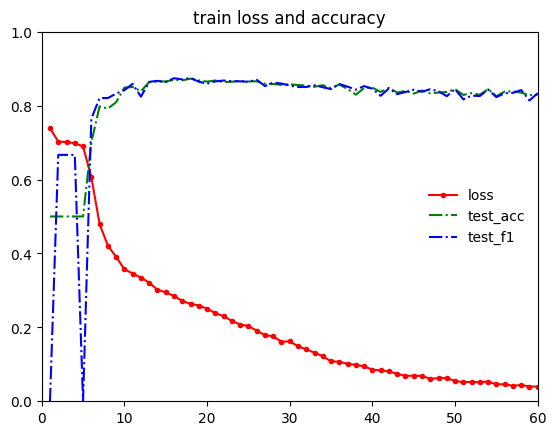

In [32]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
plt.axis([0, num_epochs, 0, 1])
# losses, test_accuracy, test_f1
plt.plot(epochs, losses, 'r.-', label='loss')
# plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'g-.', label='test_acc')
plt.plot(epochs, test_f1, 'b-.', label='test_f1')
plt.legend(loc='best', frameon=False)
plt.show()

In [33]:
result = pd.DataFrame({"train_acc": train_accuracy,
                       "train_f1": train_f1,
                      "test_acc": test_accuracy,
                      "test_f1": test_f1})
result.to_excel(file_path + 'output/3layerfa.xlsx')

In [35]:
torch.save(net.state_dict(), file_path + 'output/3layer_state_dict.pth')

# 结尾